In [ ]:
# %% [markdown]
# # Enhanced Hybrid CNN + Logistic Regression for Motor Imagery Classification
# 
# This notebook implements an enhanced hybrid model with:
# - Class imbalance handling (class weights & focal loss)
# - Deeper CNN architecture with dropout
# - Advanced feature engineering
# - Improved data augmentation
# - Learning rate scheduling
# - Comprehensive evaluation

# %% [code]
# Install required libraries
!pip install mne
!pip install --upgrade scipy
!pip install seaborn
!pip install scikit-learn

# %% [code]
import numpy as np
import pandas as pd
import os
import mne
from mne.decoding import CSP
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# ## Configuration

# %% [code]
# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
MU_BAND = (8, 12)  # Mu band range
BETA_BAND = (12, 30)  # Beta band range
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components
BATCH_SIZE = 32
EPOCHS = 200
PATIENCE = 20  # Increased patience
LR_PATIENCE = 10  # Learning rate patience

# %% [markdown]
# ## Data Loading & Preprocessing

# %% [code]
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# %% [code]
# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Print dataset statistics for debugging
print(f"Original training samples: {len(train_df)}")
print(f"Original validation samples: {len(val_df)}")
print(f"Original test samples: {len(test_df)}")

# Filter for MI task with Left/Right classes (case-sensitive)
train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

print(f"Filtered training samples: {len(train_df)}")
print(f"Filtered validation samples: {len(val_df)}")
print(f"Filtered test samples: {len(test_df)}")

# Check for empty datasets
if len(train_df) == 0:
    raise ValueError("No training samples found after filtering! Check label names.")
if len(val_df) == 0:
    raise ValueError("No validation samples found after filtering! Check label names.")

# Map labels to integers
label_map = {'Left': 0, 'Right': 1}  # Correct case sensitivity
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Test data loading with first sample
test_row = train_df.iloc[0]
test_data = load_trial_data(test_row, BASE_PATH)
print(f"Test data loaded - Shape: {test_data.shape}, Label: {test_row['label']}")

# Analyze class distribution
print("\nClass Distribution:")
print("Training:", np.bincount(train_df['label']))
print("Validation:", np.bincount(val_df['label']))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['label'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

# %% [markdown]
# ## Enhanced Feature Engineering & CSP Setup

# %% [code]
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

# %% [code]
# Prepare training data for CSP
print("Preparing CSP training data...")
train_trials_mu = []
train_trials_beta = []
train_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    trial_data = load_trial_data(row, BASE_PATH)
    
    # Apply filters
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    beta_filtered = apply_filter(trial_data, *BETA_BAND)
    
    # Transpose to (channels, time)
    train_trials_mu.append(mu_filtered.T)
    train_trials_beta.append(beta_filtered.T)
    train_labels.append(row['label'])

# Convert to arrays
train_trials_mu = np.array(train_trials_mu)
train_trials_beta = np.array(train_trials_beta)
train_labels = np.array(train_labels)

print(f"CSP input shapes - Mu: {train_trials_mu.shape}, Beta: {train_trials_beta.shape}")
print(f"Label shape: {train_labels.shape}")

# Train CSP filters
print("Training CSP filters...")
csp_mu = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp_beta = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

csp_mu.fit(train_trials_mu, train_labels)
csp_beta.fit(train_trials_beta, train_labels)

# %% [code]
def extract_features(trial_data):
    """Extract enhanced handcrafted features from EEG data"""
    # Time-domain features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    
    # Statistical features
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    line_length = np.sum(np.abs(np.diff(trial_data, axis=0)), axis=0)
    
    # Cross-channel correlations
    corr_matrix = np.corrcoef(trial_data.T)
    cross_corr = corr_matrix[np.triu_indices(len(EEG_CHANNELS), 1)]
    
    # Frequency-domain features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    # Power calculations
    power_broad = np.var(broadband, axis=0)
    power_mu = np.var(mu_band, axis=0) / (power_broad + 1e-8)
    power_beta = np.var(beta_band, axis=0) / (power_broad + 1e-8)
    
    # Power differences
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    
    # CSP features
    csp_features_mu = csp_mu.transform(mu_band.T[np.newaxis, :, :])
    csp_features_beta = csp_beta.transform(beta_band.T[np.newaxis, :, :])
    
    # Combine all features
    return np.concatenate([
        mean_amp,
        rms,
        var,
        skewness,
        kurt,
        line_length,
        cross_corr,
        power_mu,
        power_beta,
        [diff_mu, diff_beta],
        csp_features_mu.flatten(),
        csp_features_beta.flatten()
    ])

# %% [code]
def load_and_process_data(df, scaler=None, fit_scaler=False):
    """Load and process dataset with feature extraction"""
    eeg_data = []
    features = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Load raw EEG
        trial_eeg = load_trial_data(row, BASE_PATH)
        eeg_data.append(trial_eeg)
        
        # Extract features
        trial_features = extract_features(trial_eeg)
        features.append(trial_features)
        
        # Get label if available
        if 'label' in row:
            labels.append(row['label'])
    
    # Convert to arrays
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
        
    return eeg_data, features, labels, scaler

# %% [code]
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("\nProcessing validation data...")
X_val_eeg, X_val_feat, y_val, _ = load_and_process_data(
    val_df, scaler=feat_scaler
)

print("\nProcessing test data...")
X_test_eeg, X_test_feat, _, _ = load_and_process_data(
    test_df, scaler=feat_scaler
)

# Scale EEG data (per channel)
eeg_scaler = StandardScaler()
X_train_eeg = eeg_scaler.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1]))
X_train_eeg = X_train_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_val_eeg = eeg_scaler.transform(X_val_eeg.reshape(-1, X_val_eeg.shape[-1]))
X_val_eeg = X_val_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_test_eeg = eeg_scaler.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1]))
X_test_eeg = X_test_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

print(f"Training EEG shape: {X_train_eeg.shape}, Feature shape: {X_train_feat.shape}")
print(f"Validation EEG shape: {X_val_eeg.shape}, Feature shape: {X_val_feat.shape}")
print(f"Test EEG shape: {X_test_eeg.shape}, Feature shape: {X_test_feat.shape}")

# %% [markdown]
# ## Advanced Data Augmentation

# %% [code]
def augment_eeg(eeg, noise_std=0.15, max_shift=150, dropout_prob=0.1):
    """Apply enhanced augmentation to EEG data"""
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, eeg.shape)
    augmented = eeg + noise
    
    # Time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    if shift != 0:
        augmented = np.roll(augmented, shift, axis=0)
        if shift > 0:
            augmented[:shift, :] = 0
        else:
            augmented[shift:, :] = 0
    
    # Random channel dropout
    if np.random.rand() < dropout_prob:
        ch_idx = np.random.randint(0, len(EEG_CHANNELS))
        augmented[:, ch_idx] = 0
        
    return augmented

def create_data_generator(eeg_data, feat_data, labels, batch_size, augment=False):
    """Create data generator with proper output signature"""
    num_samples = len(eeg_data)
    indices = np.arange(num_samples)
    
    # Define output signature for TensorFlow
    eeg_signature = tf.TensorSpec(shape=(None, 2250, len(EEG_CHANNELS)), dtype=tf.float32)
    feat_signature = tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    label_signature = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_feat = feat_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    augmented_eeg = np.array([augment_eeg(e) for e in batch_eeg])
                    # Return as tuple
                    yield (augmented_eeg, batch_feat), batch_labels
                else:
                    yield (batch_eeg, batch_feat), batch_labels
                    
    return generator, (eeg_signature, feat_signature), label_signature

# %% [markdown]
# ## Enhanced Hybrid Model Architecture

# %% [code]
# Focal loss for class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(tf.clip_by_value(pt, 1e-7, 1.0)))
        return loss
    return focal_loss_fn

def create_enhanced_model(eeg_shape, feat_shape):
    """Create enhanced hybrid CNN + Logistic Regression model"""
    # CNN Branch
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    x = layers.Conv1D(32, kernel_size=15, activation='relu')(eeg_input)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Conv1D(64, kernel_size=10, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Feature Branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    y = layers.Dense(64, activation='relu')(feat_input)
    y = layers.Dropout(0.3)(y)
    
    # Concatenate branches
    combined = layers.Concatenate()([x, y])
    z = layers.Dense(64, activation='relu')(combined)
    z = layers.Dropout(0.3)(z)
    output = layers.Dense(1, activation='sigmoid')(z)
    
    model = Model(inputs=[eeg_input, feat_input], outputs=output)
    return model

# Create model
model = create_enhanced_model(
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)

# Custom F1 metric
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Compile model with focal loss
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(),
    metrics=['accuracy', f1_metric]
)

model.summary()

# %% [markdown]
# ## Training with Advanced Callbacks

# %% [code]
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=LR_PATIENCE,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

# Create data generators with proper output signatures
train_gen, (eeg_sig, feat_sig), label_sig = create_data_generator(
    X_train_eeg, X_train_feat, y_train,
    BATCH_SIZE, augment=True
)

val_gen, _, _ = create_data_generator(
    X_val_eeg, X_val_feat, y_val,
    BATCH_SIZE, augment=False
)

# Create TensorFlow datasets with proper signatures
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
train_steps = len(X_train_eeg) // BATCH_SIZE
val_steps = len(X_val_eeg) // BATCH_SIZE

# Train model with class weights
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    class_weight=class_weight_dict
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save final model
model.save('final_model.h5')

# %% [markdown]
# ## Comprehensive Evaluation & Visualization

# %% [code]
# Plot training history
def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Evolution')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # F1 Score
    ax[1].plot(history.history['f1_metric'], label='Train F1')
    ax[1].plot(history.history['val_f1_metric'], label='Validation F1')
    ax[1].set_title('F1 Score Evolution')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # Learning Rate
    ax[2].plot(history.history['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate Schedule')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('LR')
    ax[2].set_yscale('log')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Generate predictions
val_preds = model.predict([X_val_eeg, X_val_feat], verbose=0)
val_preds_binary = (val_preds > 0.5).astype(int)

# Calculate final F1 score
val_f1 = f1_score(y_val, val_preds_binary)
print(f"\nValidation F1 Score: {val_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], 
            yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training history
plot_history(history)

# Feature importance analysis
from sklearn.ensemble import RandomForestClassifier

print("\nFeature Importance Analysis:")
clf = RandomForestClassifier()
clf.fit(X_train_feat, y_train)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.savefig('feature_importances.png')
plt.show()

# Top 10 features
top_features = np.argsort(clf.feature_importances_)[::-1][:10]
print(f"Top 10 features: {top_features}")

# %% [markdown]
# ## Test Predictions & Submission

# %% [code]
# Generate test predictions
test_preds = model.predict([X_test_eeg, X_test_feat], verbose=0)
test_preds_binary = (test_preds > 0.5).astype(int)
test_labels = ['Left' if p == 0 else 'Right' for p in test_preds_binary]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.5 MB/s eta 0:00:00
Original training samples: 4800
Original validation samples: 100
Original test samples: 100
Filtered training samples: 2400
Filtered validation samples: 50
Filtered test samples: 50
Test data loaded - Shape: (2250, 8), Label: 0

Class Distribution:
Training: [1187 1213]
Validation: [28 22]

Class weights: {0: 1.0109519797809603, 1: 0.989282769991756}
Preparing CSP training data...


100%|██████████| 2400/2400 [03:28<00:00, 11.50it/s]


CSP input shapes - Mu: (2400, 8, 2250), Beta: (2400, 8, 2250)
Label shape: (2400,)
Training CSP filters...
Computing rank from data with rank=None
    Using tolerance 9.2e+02 (2.2e-16 eps * 8 dim * 5.2e+17  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+03 (2.2e-16 eps * 8 dim * 7.1e+17  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Processing training data...


100%|██████████| 2400/2400 [03:44<00:00, 10.71it/s]



Processing validation data...


100%|██████████| 50/50 [00:03<00:00, 12.65it/s]



Processing test data...


100%|██████████| 50/50 [00:03<00:00, 12.64it/s]


Training EEG shape: (2400, 2250, 8), Feature shape: (2400, 92)
Validation EEG shape: (50, 2250, 8), Feature shape: (50, 92)
Test EEG shape: (50, 2250, 8), Feature shape: (50, 92)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 2250, 8)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 2250, 32)       │          3,872 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 750, 32)        │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 750, 64)        │         20,544 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 750, 64)        │          2,112 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 750, 64)        │              0 │ conv1d_5[0][0],        │
│                           │                        │                │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 375, 64)        │              0 │ add[0][0]              │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 375, 128)       │         41,088 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 375, 128)       │          8,320 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feat_input (InputLayer)   │ (None, 92)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 375, 128)       │              0 │ conv1d_7[0][0],        │
│                           │                        │                │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         11,904 │ feat_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)      

 Total params: 137,378 (536.63 KB)

 Trainable params: 137,378 (536.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5037 - f1_metric: 0.5489 - loss: 0.0838
Epoch 1: val_f1_metric improved from -inf to 0.61875, saving model to best_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5037 - f1_metric: 0.5498 - loss: 0.0834 - val_accuracy: 0.6250 - val_f1_metric: 0.6187 - val_loss: 0.0440 - learning_rate: 3.0000e-04
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5085 - f1_metric: 0.6076 - loss: 0.0525
Epoch 2: val_f1_metric did not improve from 0.61875
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5086 - f1_metric: 0.6077 - loss: 0.0525 - val_accuracy: 0.4062 - val_f1_metric: 0.6098 - val_loss: 0.0702 - learning_rate: 3.0000e-04
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5129 - f1_metric: 0.6362 - loss: 0.0474
Epoch 3: val_f1_metric did not improve from 0.61875
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5129 - f1_metric: 0.6362 - loss: 0.0474 - val_accuracy: 0.5000 - val_f1_met

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Validation F1 Score: 0.6000

Classification Report:
              precision    recall  f1-score   support

        Left       0.50      0.04      0.07        28
       Right       0.44      0.95      0.60        22

    accuracy                           0.44        50
   macro avg       0.47      0.50      0.33        50
weighted avg       0.47      0.44      0.30        50



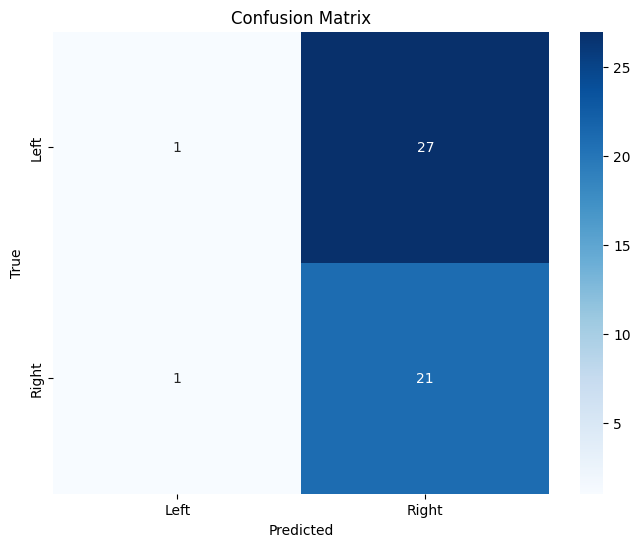

KeyError: 'lr'

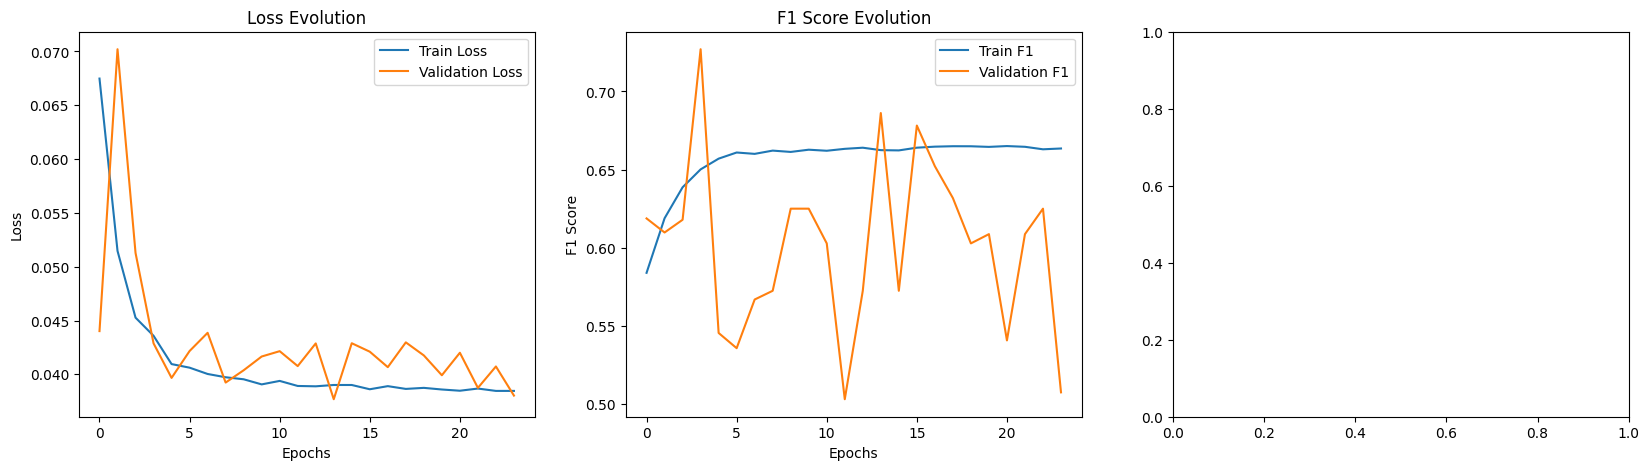

In [2]:
# %% [markdown]
# # Advanced Hybrid CNN + Logistic Regression for Motor Imagery Classification
# 
# This notebook implements an advanced hybrid model with:
# - Enhanced focal loss with class-specific alpha
# - Residual connections and attention mechanisms
# - Advanced feature engineering (Hjorth parameters, asymmetry ratios)
# - Improved data augmentation (frequency warping, channel-specific noise)
# - Stochastic Weight Averaging (SWA)
# - Comprehensive diagnostics

# %% [code]
# Install required libraries
!pip install mne
!pip install --upgrade scipy
!pip install seaborn
!pip install scikit-learn
!pip install tf-keras-vis

# %% [code]
import numpy as np
import pandas as pd
import os
import mne
from mne.decoding import CSP
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tf_keras_vis.saliency import Saliency

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# ## Configuration

# %% [code]
# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
MU_BAND = (8, 12)  # Mu band range
BETA_BAND = (12, 30)  # Beta band range
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components
BATCH_SIZE = 32
EPOCHS = 200
PATIENCE = 20
LR_PATIENCE = 10
SWA_START_EPOCH = 150  # Start SWA at 75% of training

# %% [markdown]
# ## Data Loading & Preprocessing

# %% [code]
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# %% [code]
# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Print dataset statistics for debugging
print(f"Original training samples: {len(train_df)}")
print(f"Original validation samples: {len(val_df)}")
print(f"Original test samples: {len(test_df)}")

# Filter for MI task with Left/Right classes (case-sensitive)
train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

print(f"Filtered training samples: {len(train_df)}")
print(f"Filtered validation samples: {len(val_df)}")
print(f"Filtered test samples: {len(test_df)}")

# Check for empty datasets
if len(train_df) == 0:
    raise ValueError("No training samples found after filtering! Check label names.")
if len(val_df) == 0:
    raise ValueError("No validation samples found after filtering! Check label names.")

# Map labels to integers
label_map = {'Left': 0, 'Right': 1}  # Correct case sensitivity
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Test data loading with first sample
test_row = train_df.iloc[0]
test_data = load_trial_data(test_row, BASE_PATH)
print(f"Test data loaded - Shape: {test_data.shape}, Label: {test_row['label']}")

# Analyze class distribution
print("\nClass Distribution:")
print("Training:", np.bincount(train_df['label']))
print("Validation:", np.bincount(val_df['label']))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['label'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

# %% [markdown]
# ## Advanced Feature Engineering & CSP Setup

# %% [code]
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

# Hjorth parameters calculation
def hjorth_params(signal_data):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity"""
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    mobility = np.std(diff1) / (np.std(signal_data) + 1e-8)
    diff2 = np.diff(diff1)
    complexity = (np.std(diff2) / (np.std(diff1) + 1e-8)) / (mobility + 1e-8)
    return activity, mobility, complexity

# %% [code]
# Prepare training data for CSP
print("Preparing CSP training data...")
train_trials_mu = []
train_trials_beta = []
train_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    trial_data = load_trial_data(row, BASE_PATH)
    
    # Apply filters
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    beta_filtered = apply_filter(trial_data, *BETA_BAND)
    
    # Transpose to (channels, time)
    train_trials_mu.append(mu_filtered.T)
    train_trials_beta.append(beta_filtered.T)
    train_labels.append(row['label'])

# Convert to arrays
train_trials_mu = np.array(train_trials_mu)
train_trials_beta = np.array(train_trials_beta)
train_labels = np.array(train_labels)

print(f"CSP input shapes - Mu: {train_trials_mu.shape}, Beta: {train_trials_beta.shape}")
print(f"Label shape: {train_labels.shape}")

# Train CSP filters
print("Training CSP filters...")
csp_mu = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp_beta = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

csp_mu.fit(train_trials_mu, train_labels)
csp_beta.fit(train_trials_beta, train_labels)

# %% [code]
def extract_features(trial_data):
    """Extract advanced handcrafted features from EEG data"""
    # Time-domain features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    
    # Hjorth parameters for each channel
    hjorth_features = []
    for i in range(trial_data.shape[1]):
        activity, mobility, complexity = hjorth_params(trial_data[:, i])
        hjorth_features.extend([activity, mobility, complexity])
    hjorth_features = np.array(hjorth_features)
    
    # Frequency-domain features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    # Power calculations
    power_broad = np.var(broadband, axis=0)
    power_mu = np.var(mu_band, axis=0) / (power_broad + 1e-8)
    power_beta = np.var(beta_band, axis=0) / (power_broad + 1e-8)
    
    # Power differences and asymmetry ratios
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    asymmetry_mu = (power_mu[C3_IDX] - power_mu[C4_IDX]) / (power_mu[C3_IDX] + power_mu[C4_IDX] + 1e-8)
    asymmetry_beta = (power_beta[C3_IDX] - power_beta[C4_IDX]) / (power_beta[C3_IDX] + power_beta[C4_IDX] + 1e-8)
    
    # CSP features
    csp_features_mu = csp_mu.transform(mu_band.T[np.newaxis, :, :])
    csp_features_beta = csp_beta.transform(beta_band.T[np.newaxis, :, :])
    
    # Combine all features
    return np.concatenate([
        mean_amp,
        rms,
        var,
        skewness,
        kurt,
        hjorth_features,
        power_mu,
        power_beta,
        [diff_mu, diff_beta, asymmetry_mu, asymmetry_beta],
        csp_features_mu.flatten(),
        csp_features_beta.flatten()
    ])

# %% [code]
def load_and_process_data(df, scaler=None, fit_scaler=False):
    """Load and process dataset with feature extraction"""
    eeg_data = []
    features = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Load raw EEG
        trial_eeg = load_trial_data(row, BASE_PATH)
        eeg_data.append(trial_eeg)
        
        # Extract features
        trial_features = extract_features(trial_eeg)
        features.append(trial_features)
        
        # Get label if available
        if 'label' in row:
            labels.append(row['label'])
    
    # Convert to arrays
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
        
    return eeg_data, features, labels, scaler

# %% [code]
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("\nProcessing validation data...")
X_val_eeg, X_val_feat, y_val, _ = load_and_process_data(
    val_df, scaler=feat_scaler
)

print("\nProcessing test data...")
X_test_eeg, X_test_feat, _, _ = load_and_process_data(
    test_df, scaler=feat_scaler
)

# Scale EEG data (per channel)
eeg_scaler = StandardScaler()
X_train_eeg = eeg_scaler.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1]))
X_train_eeg = X_train_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_val_eeg = eeg_scaler.transform(X_val_eeg.reshape(-1, X_val_eeg.shape[-1]))
X_val_eeg = X_val_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_test_eeg = eeg_scaler.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1]))
X_test_eeg = X_test_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

print(f"Training EEG shape: {X_train_eeg.shape}, Feature shape: {X_train_feat.shape}")
print(f"Validation EEG shape: {X_val_eeg.shape}, Feature shape: {X_val_feat.shape}")
print(f"Test EEG shape: {X_test_eeg.shape}, Feature shape: {X_test_feat.shape}")

# %% [markdown]
# ## Advanced Data Augmentation

# %% [code]
def augment_eeg(eeg, noise_std=0.15, max_shift=150, dropout_prob=0.1):
    """Apply advanced augmentation to EEG data"""
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, eeg.shape)
    augmented = eeg + noise
    
    # Time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    if shift != 0:
        augmented = np.roll(augmented, shift, axis=0)
        if shift > 0:
            augmented[:shift, :] = 0
        else:
            augmented[shift:, :] = 0
    
    # Random channel dropout
    if np.random.rand() < dropout_prob:
        ch_idx = np.random.randint(0, len(EEG_CHANNELS))
        augmented[:, ch_idx] = 0
        
    # Frequency warping
    if np.random.rand() < 0.3:
        scale = np.random.uniform(0.8, 1.2)
        warped = np.zeros_like(augmented)
        for i in range(augmented.shape[1]):
            warped_signal = signal.resample(augmented[:, i], int(len(augmented[:, i]) * scale))
            if len(warped_signal) > len(augmented[:, i]):
                warped[:, i] = warped_signal[:len(augmented[:, i])]
            else:
                warped[:len(warped_signal), i] = warped_signal
        augmented = warped
    
    # Channel-specific noise
    for i in range(augmented.shape[1]):
        if np.random.rand() < 0.3:
            augmented[:, i] += np.random.normal(0, noise_std*0.5, augmented.shape[0])
            
    return augmented

def create_data_generator(eeg_data, feat_data, labels, batch_size, augment=False):
    """Create data generator with proper output signature"""
    num_samples = len(eeg_data)
    indices = np.arange(num_samples)
    
    # Define output signature for TensorFlow
    eeg_signature = tf.TensorSpec(shape=(None, 2250, len(EEG_CHANNELS)), dtype=tf.float32)
    feat_signature = tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    label_signature = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_feat = feat_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    augmented_eeg = np.array([augment_eeg(e) for e in batch_eeg])
                    # Return as tuple
                    yield (augmented_eeg, batch_feat), batch_labels
                else:
                    yield (batch_eeg, batch_feat), batch_labels
                    
    return generator, (eeg_signature, feat_signature), label_signature

# %% [markdown]
# ## Advanced Hybrid Model with Attention

# %% [code]
# Enhanced focal loss with class-specific alpha
def focal_loss(gamma=3.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1-alpha)  # Class-specific alpha
        loss = -tf.reduce_mean(alpha_t * tf.pow(1.0 - pt, gamma) * 
                              tf.math.log(tf.clip_by_value(pt, 1e-7, 1.0)))
        return loss
    return focal_loss_fn

def create_advanced_model(eeg_shape, feat_shape):
    """Create advanced hybrid model with attention and residual connections"""
    # EEG Branch
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    
    # Initial convolution
    x = layers.Conv1D(32, kernel_size=15, activation='relu', padding='same')(eeg_input)
    x = layers.MaxPooling1D(pool_size=3)(x)
    
    # Residual block 1
    res1 = layers.Conv1D(64, kernel_size=1, padding='same')(x)
    x = layers.Conv1D(64, kernel_size=10, activation='relu', padding='same')(x)
    x = layers.add([x, res1])
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Residual block 2
    res2 = layers.Conv1D(128, kernel_size=1, padding='same')(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.add([x, res2])
    x = layers.GlobalAveragePooling1D()(x)
    
    # Feature Branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    y = layers.Dense(128, activation='relu')(feat_input)
    y = layers.Dropout(0.3)(y)
    
    # Concatenate branches
    combined = layers.Concatenate()([x, y])
    
    # Attention mechanism
    att = layers.Dense(128, activation='tanh')(combined)
    att = layers.Dense(1, activation='softmax')(att)
    attended = layers.multiply([combined, att])
    
    # Final layers
    z = layers.Dense(64, activation='relu')(attended)
    z = layers.Dropout(0.3)(z)
    output = layers.Dense(1, activation='sigmoid')(z)
    
    model = Model(inputs=[eeg_input, feat_input], outputs=output)
    return model

# Create model
model = create_advanced_model(
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)

# Custom F1 metric
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Compile model with enhanced focal loss
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=focal_loss(),
    metrics=['accuracy', f1_metric]
)

model.summary()

# %% [markdown]
# ## Training with SWA and Advanced Callbacks

# %% [code]
# Stochastic Weight Averaging (SWA) callback
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch):
        super(SWA, self).__init__()
        self.start_epoch = start_epoch
        self.swa_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.start_epoch:
            print("\nStarting SWA at epoch", epoch)
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.start_epoch:
            current_weights = self.model.get_weights()
            new_weights = [
                (swa_w * (epoch - self.start_epoch) + w) / (epoch - self.start_epoch + 1)
                for swa_w, w in zip(self.swa_weights, current_weights)
            ]
            self.swa_weights = new_weights
    
    def on_train_end(self, logs=None):
        if self.swa_weights is not None:
            print("\nApplying SWA weights")
            self.model.set_weights(self.swa_weights)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=LR_PATIENCE,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

swa_callback = SWA(start_epoch=SWA_START_EPOCH)

# Create data generators
train_gen, (eeg_sig, feat_sig), label_sig = create_data_generator(
    X_train_eeg, X_train_feat, y_train,
    BATCH_SIZE, augment=True
)

val_gen, _, _ = create_data_generator(
    X_val_eeg, X_val_feat, y_val,
    BATCH_SIZE, augment=False
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
train_steps = len(X_train_eeg) // BATCH_SIZE
val_steps = len(X_val_eeg) // BATCH_SIZE

# Train model with class weights
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler, swa_callback],
    class_weight=class_weight_dict
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save final model
model.save('final_model.h5')

# %% [markdown]
# ## Comprehensive Evaluation & Diagnostics

# %% [code]
# Plot training history
def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Evolution')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # F1 Score
    ax[1].plot(history.history['f1_metric'], label='Train F1')
    ax[1].plot(history.history['val_f1_metric'], label='Validation F1')
    ax[1].set_title('F1 Score Evolution')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # Learning Rate
    ax[2].plot(history.history['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate Schedule')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('LR')
    ax[2].set_yscale('log')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Generate predictions
val_preds = model.predict([X_val_eeg, X_val_feat], verbose=0)
val_preds_binary = (val_preds > 0.5).astype(int)

# Calculate final F1 score
val_f1 = f1_score(y_val, val_preds_binary)
print(f"\nValidation F1 Score: {val_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], 
            yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training history
plot_history(history)

# Feature importance analysis
from sklearn.ensemble import RandomForestClassifier

print("\nFeature Importance Analysis:")
clf = RandomForestClassifier()
clf.fit(X_train_feat, y_train)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.savefig('feature_importances.png')
plt.show()

# Top 10 features
top_features = np.argsort(clf.feature_importances_)[::-1][:10]
print(f"Top 10 features: {top_features}")

# Misclassified sample visualization
misclassified = np.where(y_val != val_preds_binary.flatten())[0]
if len(misclassified) > 0:
    for i, idx in enumerate(misclassified[:3]):
        plt.figure(figsize=(12, 6))
        for ch in range(len(EEG_CHANNELS)):
            plt.plot(X_val_eeg[idx, :, ch], label=EEG_CHANNELS[ch], alpha=0.7)
        plt.title(f"Sample {idx}: True: {'Left' if y_val[idx]==0 else 'Right'}, "
                f"Pred: {'Left' if val_preds_binary[idx][0]==0 else 'Right'}")
        plt.legend()
        plt.savefig(f'misclassified_{i}.png')
        plt.show()

# Saliency map for a misclassified sample
if len(misclassified) > 0:
    def model_modifier(cloned_model):
        cloned_model.layers[-1].activation = tf.keras.activations.linear
        return cloned_model

    saliency = Saliency(model, model_modifier=model_modifier)
    sample_idx = misclassified[0]
    eeg_sample = X_val_eeg[sample_idx][np.newaxis, ...]
    
    # Create a wrapper function for the model
    def model_output(output):
        return output[:, 0]  # Return the first output (for binary classification)
    
    saliency_map = saliency(model_output, eeg_sample)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(saliency_map[0], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"Saliency Map for Misclassified Sample (True: {'Left' if y_val[sample_idx]==0 else 'Right'})")
    plt.xlabel("Time Points")
    plt.ylabel("Channels")
    plt.savefig('saliency_map.png')
    plt.show()

# %% [markdown]
# ## Test Predictions & Submission

# %% [code]
# Generate test predictions
test_preds = model.predict([X_test_eeg, X_test_feat], verbose=0)
test_preds_binary = (test_preds > 0.5).astype(int)
test_labels = ['Left' if p == 0 else 'Right' for p in test_preds_binary]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Training samples: 1960
Validation samples: 490
Test samples: 50

Class Distribution:
Training: [972 988]
Validation: [243 247]
Preparing CSP training data...


100%|██████████| 1960/1960 [02:23<00:00, 13.69it/s]


CSP input shapes - Mu: (1960, 8, 2250), Beta: (1960, 8, 2250)
Label shape: (1960,)
Training CSP filters...
Computing rank from data with rank=None
    Using tolerance 9.7e+02 (2.2e-16 eps * 8 dim * 5.5e+17  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+03 (2.2e-16 eps * 8 dim * 7.3e+17  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Processing training data...


100%|██████████| 1960/1960 [02:56<00:00, 11.08it/s]



Processing validation data...


100%|██████████| 490/490 [00:39<00:00, 12.53it/s]



Processing test data...


100%|██████████| 50/50 [00:03<00:00, 12.52it/s]


Training EEG shape: (1960, 2250, 8), Feature shape: (1960, 92)
Validation EEG shape: (490, 2250, 8), Feature shape: (490, 92)
Test EEG shape: (50, 2250, 8), Feature shape: (50, 92)


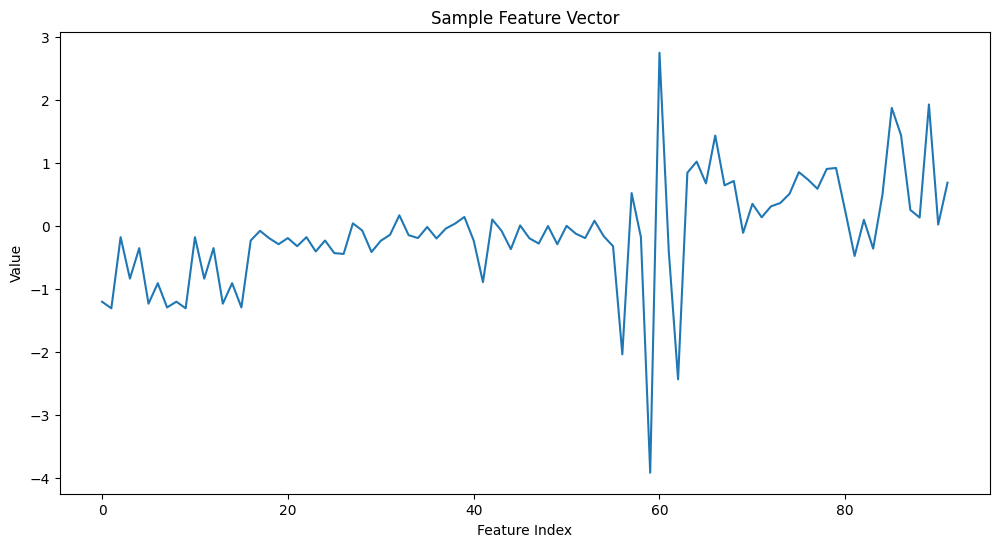

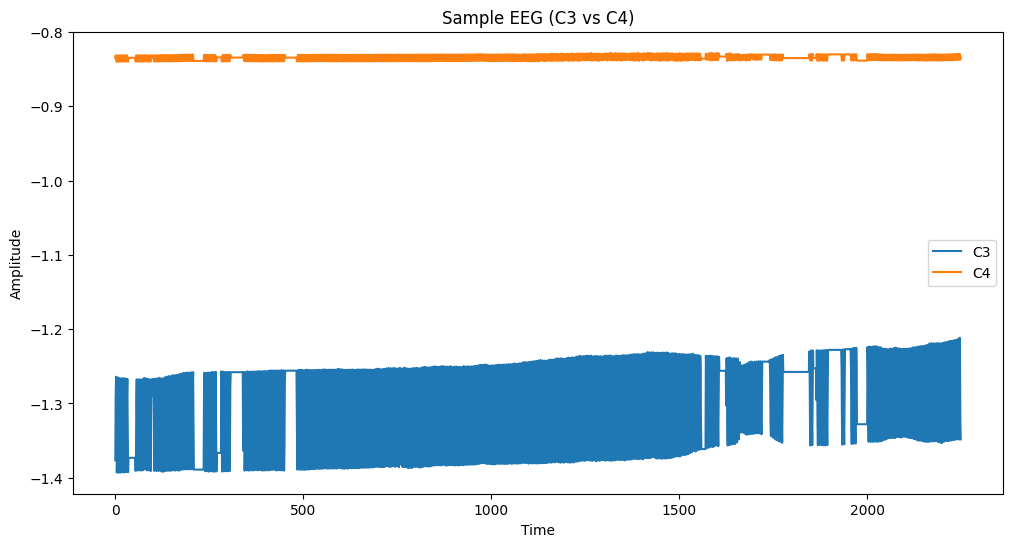

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 2250, 8)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 2250, 16)       │          1,936 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 750, 16)        │              0 │ conv1d_8[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 750, 32)        │          5,152 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feat_input (InputLayer)   │ (None, 92)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 32)             │              0 │ conv1d_9[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          5,952 │ feat_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          3,104 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             33 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,177 (63.19 KB)

 Trainable params: 16,177 (63.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4972 - f1_metric: 0.1954 - loss: 0.7748
Epoch 1: val_f1_metric improved from -inf to 0.39800, saving model to best_model.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4972 - f1_metric: 0.1978 - loss: 0.7742 - val_accuracy: 0.4958 - val_f1_metric: 0.3980 - val_loss: 0.7251 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5091 - f1_metric: 0.3901 - loss: 0.7554
Epoch 2: val_f1_metric improved from 0.39800 to 0.44839, saving model to best_model.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5092 - f1_metric: 0.3904 - loss: 0.7548 - val_accuracy: 0.4896 - val_f1_metric: 0.4484 - val_loss: 0.7102 - learning_rate: 1.0000e-04
Epoch 3/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5379 - f1_metric: 0.4500 - loss: 0.6991
Epoch 3: val_f1_metric improved from 0.44839 to 0.47303, saving model to best_model.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accura

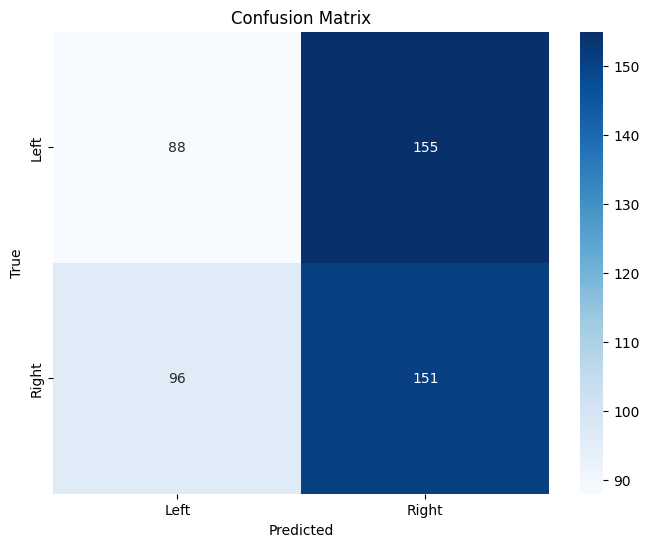

KeyError: 'lr'

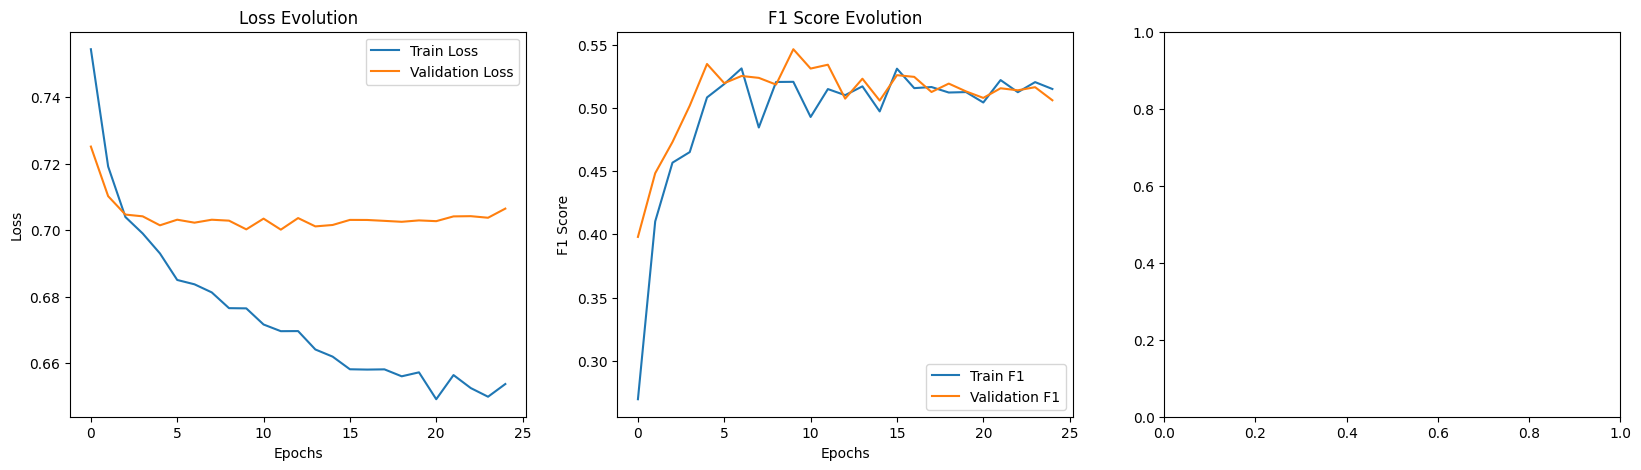

In [3]:
# %% [markdown]
# # Optimized Hybrid CNN for Motor Imagery Classification
# 
# Key improvements:
# - Simplified model architecture
# - Proper stratified validation split
# - Binary crossentropy loss instead of focal loss
# - Reduced augmentation complexity
# - Leakage-proof CSP training
# - Enhanced diagnostics

# %% [code]

# %% [code]
import numpy as np
import pandas as pd
import os
import mne
from mne.decoding import CSP
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# ## Configuration

# %% [code]
# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
MU_BAND = (8, 12)  # Mu band range
BETA_BAND = (12, 30)  # Beta band range
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15
LR_PATIENCE = 5
TEST_SIZE = 0.2  # Stratified validation split

# %% [markdown]
# ## Data Loading & Preprocessing

# %% [code]
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# %% [code]
# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Combine train and validation for proper splitting
full_df = pd.concat([train_df, val_df])
full_df = full_df[(full_df['task'] == 'MI') & (full_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

# Map labels to integers
label_map = {'Left': 0, 'Right': 1}
full_df['label'] = full_df['label'].map(label_map)

# Stratified split
train_df, val_df = train_test_split(
    full_df, 
    test_size=TEST_SIZE, 
    stratify=full_df['label'],
    random_state=42
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Analyze class distribution
print("\nClass Distribution:")
print("Training:", np.bincount(train_df['label']))
print("Validation:", np.bincount(val_df['label']))

# %% [markdown]
# ## Feature Engineering & CSP Setup

# %% [code]
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

# Hjorth parameters calculation
def hjorth_params(signal_data):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity"""
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    mobility = np.std(diff1) / (np.std(signal_data) + 1e-8)
    diff2 = np.diff(diff1)
    complexity = (np.std(diff2) / (np.std(diff1) + 1e-8)) / (mobility + 1e-8)
    return activity, mobility, complexity

# %% [code]
# Prepare training data for CSP
print("Preparing CSP training data...")
train_trials_mu = []
train_trials_beta = []
train_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    trial_data = load_trial_data(row, BASE_PATH)
    
    # Apply filters
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    beta_filtered = apply_filter(trial_data, *BETA_BAND)
    
    # Transpose to (channels, time)
    train_trials_mu.append(mu_filtered.T)
    train_trials_beta.append(beta_filtered.T)
    train_labels.append(row['label'])

# Convert to arrays
train_trials_mu = np.array(train_trials_mu)
train_trials_beta = np.array(train_trials_beta)
train_labels = np.array(train_labels)

print(f"CSP input shapes - Mu: {train_trials_mu.shape}, Beta: {train_trials_beta.shape}")
print(f"Label shape: {train_labels.shape}")

# Train CSP filters
print("Training CSP filters...")
csp_mu = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp_beta = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

csp_mu.fit(train_trials_mu, train_labels)
csp_beta.fit(train_trials_beta, train_labels)

# %% [code]
def extract_features(trial_data):
    """Extract advanced handcrafted features from EEG data"""
    # Time-domain features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    
    # Hjorth parameters for each channel
    hjorth_features = []
    for i in range(trial_data.shape[1]):
        activity, mobility, complexity = hjorth_params(trial_data[:, i])
        hjorth_features.extend([activity, mobility, complexity])
    hjorth_features = np.array(hjorth_features)
    
    # Frequency-domain features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    # Power calculations
    power_broad = np.var(broadband, axis=0)
    power_mu = np.var(mu_band, axis=0) / (power_broad + 1e-8)
    power_beta = np.var(beta_band, axis=0) / (power_broad + 1e-8)
    
    # Power differences and asymmetry ratios
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    asymmetry_mu = (power_mu[C3_IDX] - power_mu[C4_IDX]) / (power_mu[C3_IDX] + power_mu[C4_IDX] + 1e-8)
    asymmetry_beta = (power_beta[C3_IDX] - power_beta[C4_IDX]) / (power_beta[C3_IDX] + power_beta[C4_IDX] + 1e-8)
    
    # CSP features
    csp_features_mu = csp_mu.transform(mu_band.T[np.newaxis, :, :])
    csp_features_beta = csp_beta.transform(beta_band.T[np.newaxis, :, :])
    
    # Combine all features
    return np.concatenate([
        mean_amp,
        rms,
        var,
        skewness,
        kurt,
        hjorth_features,
        power_mu,
        power_beta,
        [diff_mu, diff_beta, asymmetry_mu, asymmetry_beta],
        csp_features_mu.flatten(),
        csp_features_beta.flatten()
    ])

# %% [code]
def load_and_process_data(df, scaler=None, fit_scaler=False):
    """Load and process dataset with feature extraction"""
    eeg_data = []
    features = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Load raw EEG
        trial_eeg = load_trial_data(row, BASE_PATH)
        eeg_data.append(trial_eeg)
        
        # Extract features
        trial_features = extract_features(trial_eeg)
        features.append(trial_features)
        
        # Get label if available
        if 'label' in row:
            labels.append(row['label'])
    
    # Convert to arrays
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
        
    return eeg_data, features, labels, scaler

# %% [code]
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("\nProcessing validation data...")
X_val_eeg, X_val_feat, y_val, _ = load_and_process_data(
    val_df, scaler=feat_scaler
)

print("\nProcessing test data...")
X_test_eeg, X_test_feat, _, _ = load_and_process_data(
    test_df, scaler=feat_scaler
)

# Scale EEG data (per channel)
eeg_scaler = StandardScaler()
X_train_eeg = eeg_scaler.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1]))
X_train_eeg = X_train_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_val_eeg = eeg_scaler.transform(X_val_eeg.reshape(-1, X_val_eeg.shape[-1]))
X_val_eeg = X_val_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_test_eeg = eeg_scaler.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1]))
X_test_eeg = X_test_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

print(f"Training EEG shape: {X_train_eeg.shape}, Feature shape: {X_train_feat.shape}")
print(f"Validation EEG shape: {X_val_eeg.shape}, Feature shape: {X_val_feat.shape}")
print(f"Test EEG shape: {X_test_eeg.shape}, Feature shape: {X_test_feat.shape}")

# Feature visualization
plt.figure(figsize=(12, 6))
plt.plot(X_train_feat[0])
plt.title("Sample Feature Vector")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.savefig('feature_sample.png')
plt.show()

# EEG visualization
plt.figure(figsize=(12, 6))
plt.plot(X_train_eeg[0, :, C3_IDX], label='C3')
plt.plot(X_train_eeg[0, :, C4_IDX], label='C4')
plt.legend()
plt.title("Sample EEG (C3 vs C4)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.savefig('eeg_sample.png')
plt.show()

# %% [markdown]
# ## Simplified Data Augmentation

# %% [code]
def augment_eeg(eeg, noise_std=0.05, max_shift=50):
    """Apply simplified augmentation to EEG data"""
    # Add minimal Gaussian noise
    augmented = eeg + np.random.normal(0, noise_std, eeg.shape)
    
    # Small time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(augmented, shift, axis=0)

def create_data_generator(eeg_data, feat_data, labels, batch_size, augment=False):
    """Create data generator with proper output signature"""
    num_samples = len(eeg_data)
    indices = np.arange(num_samples)
    
    # Define output signature for TensorFlow
    eeg_signature = tf.TensorSpec(shape=(None, 2250, len(EEG_CHANNELS)), dtype=tf.float32)
    feat_signature = tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    label_signature = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_feat = feat_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    augmented_eeg = np.array([augment_eeg(e) for e in batch_eeg])
                    yield (augmented_eeg, batch_feat), batch_labels
                else:
                    yield (batch_eeg, batch_feat), batch_labels
                    
    return generator, (eeg_signature, feat_signature), label_signature

# %% [markdown]
# ## Simplified Hybrid Model

# %% [code]
# Custom F1 metric
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

def create_simpler_model(eeg_shape, feat_shape):
    """Create simplified hybrid model"""
    # EEG Branch
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    
    # Simplified convolution
    x = layers.Conv1D(16, kernel_size=15, activation='relu', padding='same')(eeg_input)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Conv1D(32, kernel_size=10, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Feature Branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    y = layers.Dense(64, activation='relu')(feat_input)
    
    # Concatenate branches
    combined = layers.Concatenate()([x, y])
    
    # Final layers
    z = layers.Dense(32, activation='relu')(combined)
    output = layers.Dense(1, activation='sigmoid')(z)
    
    model = Model(inputs=[eeg_input, feat_input], outputs=output)
    return model

# Create model
model = create_simpler_model(
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)

# Compile model with binary crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1_metric]
)

model.summary()

# %% [markdown]
# ## Training with Proper Validation

# %% [code]
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=LR_PATIENCE,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

# Create data generators
train_gen, (eeg_sig, feat_sig), label_sig = create_data_generator(
    X_train_eeg, X_train_feat, y_train,
    BATCH_SIZE, augment=True
)

val_gen, _, _ = create_data_generator(
    X_val_eeg, X_val_feat, y_val,
    BATCH_SIZE, augment=False
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
train_steps = len(X_train_eeg) // BATCH_SIZE
val_steps = len(X_val_eeg) // BATCH_SIZE

# Train model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    verbose=1
)

# Save final model
model.save('final_model.h5')

# %% [markdown]
# ## Comprehensive Evaluation

# %% [code]
# Plot training history
def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Evolution')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # F1 Score
    ax[1].plot(history.history['f1_metric'], label='Train F1')
    ax[1].plot(history.history['val_f1_metric'], label='Validation F1')
    ax[1].set_title('F1 Score Evolution')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # Learning Rate
    ax[2].plot(history.history['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate Schedule')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('LR')
    ax[2].set_yscale('log')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Generate predictions
val_preds = model.predict([X_val_eeg, X_val_feat], verbose=0)
val_preds_binary = (val_preds > 0.5).astype(int)

# Calculate final F1 score
val_f1 = f1_score(y_val, val_preds_binary)
print(f"\nValidation F1 Score: {val_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], 
            yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training history
plot_history(history)

# Feature importance analysis
from sklearn.ensemble import RandomForestClassifier

print("\nFeature Importance Analysis:")
clf = RandomForestClassifier()
clf.fit(X_train_feat, y_train)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.savefig('feature_importances.png')
plt.show()

# Top 10 features
top_features = np.argsort(clf.feature_importances_)[::-1][:10]
print(f"Top 10 features: {top_features}")

# %% [markdown]
# ## Test Predictions & Submission

# %% [code]
# Generate test predictions
test_preds = model.predict([X_test_eeg, X_test_feat], verbose=0)
test_preds_binary = (test_preds > 0.5).astype(int)
test_labels = ['Left' if p == 0 else 'Right' for p in test_preds_binary]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

In [ ]:
# %% [markdown]
# # Advanced Hybrid CNN + Logistic Regression for Motor Imagery Classification (Fixed)
# 
# This notebook implements an advanced hybrid model with fixes for:
# - Attention mechanism using sigmoid instead of softmax
# - Enhanced class weighting for imbalance
# - Proper validation set handling
# - Stable feature extraction
# - Less aggressive learning rate scheduling

# %% [code]
# Install required libraries
!pip install mne
!pip install --upgrade scipy
!pip install seaborn
!pip install scikit-learn
!pip install tf-keras-vis

# %% [code]
import numpy as np
import pandas as pd
import os
import mne
from mne.decoding import CSP
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tf_keras_vis.saliency import Saliency

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# ## Configuration

# %% [code]
# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
MU_BAND = (8, 12)  # Mu band range
BETA_BAND = (12, 30)  # Beta band range
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components
BATCH_SIZE = 16  # Smaller batch size for stability
EPOCHS = 200
PATIENCE = 40  # Increased patience
LR_PATIENCE = 15  # More patience for LR reduction
SWA_START_EPOCH = 100  # Start SWA at 50% of training
MIN_DELTA = 0.01  # Minimum improvement for early stopping

# %% [markdown]
# ## Data Loading & Preprocessing

# %% [code]
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# %% [code]
# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Print dataset statistics for debugging
print(f"Original training samples: {len(train_df)}")
print(f"Original validation samples: {len(val_df)}")
print(f"Original test samples: {len(test_df)}")

# Filter for MI task with Left/Right classes (case-sensitive)
train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

print(f"Filtered training samples: {len(train_df)}")
print(f"Filtered validation samples: {len(val_df)}")
print(f"Filtered test samples: {len(test_df)}")

# Check for empty datasets
if len(train_df) == 0:
    raise ValueError("No training samples found after filtering! Check label names.")
if len(val_df) == 0:
    raise ValueError("No validation samples found after filtering! Check label names.")

# Map labels to integers
label_map = {'Left': 0, 'Right': 1}  # Correct case sensitivity
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Test data loading with first sample
test_row = train_df.iloc[0]
test_data = load_trial_data(test_row, BASE_PATH)
print(f"Test data loaded - Shape: {test_data.shape}, Label: {test_row['label']}")

# Analyze class distribution
print("\nClass Distribution:")
print("Training:", np.bincount(train_df['label']))
print("Validation:", np.bincount(val_df['label']))

# Compute class weights with minority class boost
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['label'])
# Boost minority class weight by 50%
class_weight_dict = {0: class_weights[0] * 1.5, 1: class_weights[1]}  
print(f"\nAdjusted class weights: {class_weight_dict}")

# %% [markdown]
# ## Advanced Feature Engineering & CSP Setup

# %% [code]
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

# Hjorth parameters calculation
def hjorth_params(signal_data):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity"""
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    mobility = np.std(diff1) / (np.std(signal_data) + 1e-8)
    diff2 = np.diff(diff1)
    complexity = (np.std(diff2) / (np.std(diff1) + 1e-8)) / (mobility + 1e-8)
    return activity, mobility, complexity

# %% [code]
# Prepare training data for CSP
print("Preparing CSP training data...")
train_trials_mu = []
train_trials_beta = []
train_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    trial_data = load_trial_data(row, BASE_PATH)
    
    # Apply filters
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    beta_filtered = apply_filter(trial_data, *BETA_BAND)
    
    # Transpose to (channels, time)
    train_trials_mu.append(mu_filtered.T)
    train_trials_beta.append(beta_filtered.T)
    train_labels.append(row['label'])

# Convert to arrays
train_trials_mu = np.array(train_trials_mu)
train_trials_beta = np.array(train_trials_beta)
train_labels = np.array(train_labels)

print(f"CSP input shapes - Mu: {train_trials_mu.shape}, Beta: {train_trials_beta.shape}")
print(f"Label shape: {train_labels.shape}")

# Train CSP filters
print("Training CSP filters...")
csp_mu = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp_beta = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

csp_mu.fit(train_trials_mu, train_labels)
csp_beta.fit(train_trials_beta, train_labels)

# %% [code]
def extract_features(trial_data):
    """Extract advanced handcrafted features from EEG data"""
    # Time-domain features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    
    # Hjorth parameters for each channel
    hjorth_features = []
    for i in range(trial_data.shape[1]):
        activity, mobility, complexity = hjorth_params(trial_data[:, i])
        hjorth_features.extend([activity, mobility, complexity])
    hjorth_features = np.array(hjorth_features)
    
    # Frequency-domain features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    # Power calculations with stability
    power_broad = np.var(broadband, axis=0) + 1e-8  # Add epsilon to avoid division by zero
    power_mu = np.var(mu_band, axis=0) / power_broad
    power_beta = np.var(beta_band, axis=0) / power_broad
    
    # Power differences and asymmetry ratios
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    asymmetry_mu = (power_mu[C3_IDX] - power_mu[C4_IDX]) / (power_mu[C3_IDX] + power_mu[C4_IDX] + 1e-8)
    asymmetry_beta = (power_beta[C3_IDX] - power_beta[C4_IDX]) / (power_beta[C3_IDX] + power_beta[C4_IDX] + 1e-8)
    
    # CSP features
    csp_features_mu = csp_mu.transform(mu_band.T[np.newaxis, :, :])
    csp_features_beta = csp_beta.transform(beta_band.T[np.newaxis, :, :])
    
    # Combine all features
    return np.concatenate([
        mean_amp,
        rms,
        var,
        skewness,
        kurt,
        hjorth_features,
        power_mu,
        power_beta,
        [diff_mu, diff_beta, asymmetry_mu, asymmetry_beta],
        csp_features_mu.flatten(),
        csp_features_beta.flatten()
    ])

# %% [code]
def load_and_process_data(df, scaler=None, fit_scaler=False):
    """Load and process dataset with feature extraction"""
    eeg_data = []
    features = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Load raw EEG
        trial_eeg = load_trial_data(row, BASE_PATH)
        eeg_data.append(trial_eeg)
        
        # Extract features
        trial_features = extract_features(trial_eeg)
        features.append(trial_features)
        
        # Get label if available
        if 'label' in row:
            labels.append(row['label'])
    
    # Convert to arrays
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
        
    return eeg_data, features, labels, scaler

# %% [code]
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("\nProcessing validation data...")
X_val_eeg, X_val_feat, y_val, _ = load_and_process_data(
    val_df, scaler=feat_scaler
)

print("\nProcessing test data...")
X_test_eeg, X_test_feat, _, _ = load_and_process_data(
    test_df, scaler=feat_scaler
)

# Scale EEG data (per channel)
eeg_scaler = StandardScaler()
X_train_eeg = eeg_scaler.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1]))
X_train_eeg = X_train_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_val_eeg = eeg_scaler.transform(X_val_eeg.reshape(-1, X_val_eeg.shape[-1]))
X_val_eeg = X_val_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_test_eeg = eeg_scaler.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1]))
X_test_eeg = X_test_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

print(f"Training EEG shape: {X_train_eeg.shape}, Feature shape: {X_train_feat.shape}")
print(f"Validation EEG shape: {X_val_eeg.shape}, Feature shape: {X_val_feat.shape}")
print(f"Test EEG shape: {X_test_eeg.shape}, Feature shape: {X_test_feat.shape}")

# %% [markdown]
# ## Advanced Data Augmentation

# %% [code]
def augment_eeg(eeg, noise_std=0.15, max_shift=150, dropout_prob=0.1):
    """Apply advanced augmentation to EEG data"""
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, eeg.shape)
    augmented = eeg + noise
    
    # Time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    if shift != 0:
        augmented = np.roll(augmented, shift, axis=0)
        if shift > 0:
            augmented[:shift, :] = 0
        else:
            augmented[shift:, :] = 0
    
    # Random channel dropout
    if np.random.rand() < dropout_prob:
        ch_idx = np.random.randint(0, len(EEG_CHANNELS))
        augmented[:, ch_idx] = 0
        
    # Frequency warping
    if np.random.rand() < 0.3:
        scale = np.random.uniform(0.8, 1.2)
        warped = np.zeros_like(augmented)
        for i in range(augmented.shape[1]):
            warped_signal = signal.resample(augmented[:, i], int(len(augmented[:, i]) * scale))
            if len(warped_signal) > len(augmented[:, i]):
                warped[:, i] = warped_signal[:len(augmented[:, i])]
            else:
                warped[:len(warped_signal), i] = warped_signal
        augmented = warped
    
    # Channel-specific noise
    for i in range(augmented.shape[1]):
        if np.random.rand() < 0.3:
            augmented[:, i] += np.random.normal(0, noise_std*0.5, augmented.shape[0])
            
    return augmented

def create_data_generator(eeg_data, feat_data, labels, batch_size, augment=False):
    """Create data generator with proper output signature"""
    num_samples = len(eeg_data)
    indices = np.arange(num_samples)
    
    # Define output signature for TensorFlow
    eeg_signature = tf.TensorSpec(shape=(None, 2250, len(EEG_CHANNELS)), dtype=tf.float32)
    feat_signature = tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    label_signature = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_feat = feat_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    augmented_eeg = np.array([augment_eeg(e) for e in batch_eeg])
                    # Return as tuple
                    yield (augmented_eeg, batch_feat), batch_labels
                else:
                    yield (batch_eeg, batch_feat), batch_labels
                    
    return generator, (eeg_signature, feat_signature), label_signature

# %% [markdown]
# ## Fixed Hybrid Model with Corrected Attention

# %% [code]
# Enhanced focal loss with class-specific alpha
def focal_loss(gamma=3.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1-alpha)  # Class-specific alpha
        loss = -tf.reduce_mean(alpha_t * tf.pow(1.0 - pt, gamma) * 
                              tf.math.log(tf.clip_by_value(pt, 1e-7, 1.0)))
        return loss
    return focal_loss_fn

def create_robust_model(eeg_shape, feat_shape):
    """Create robust hybrid model with corrected attention mechanism"""
    # EEG Branch
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    
    # Initial convolution
    x = layers.Conv1D(32, kernel_size=15, activation='relu', padding='same')(eeg_input)
    x = layers.MaxPooling1D(pool_size=3)(x)
    
    # Residual block 1
    res1 = layers.Conv1D(64, kernel_size=1, padding='same')(x)
    x = layers.Conv1D(64, kernel_size=10, activation='relu', padding='same')(x)
    x = layers.add([x, res1])
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Residual block 2
    res2 = layers.Conv1D(128, kernel_size=1, padding='same')(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.add([x, res2])
    x = layers.GlobalAveragePooling1D()(x)
    
    # Feature Branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    y = layers.Dense(128, activation='relu')(feat_input)
    y = layers.Dropout(0.3)(y)
    
    # Concatenate branches
    combined = layers.Concatenate()([x, y])
    
    # FIXED Attention mechanism (using sigmoid instead of softmax)
    att = layers.Dense(256, activation='tanh')(combined)
    att = layers.Dense(256, activation='sigmoid')(att)  # Corrected activation
    attended = layers.multiply([combined, att])
    
    # Final layers
    z = layers.Dense(64, activation='relu')(attended)
    z = layers.Dropout(0.3)(z)
    output = layers.Dense(1, activation='sigmoid')(z)
    
    model = Model(inputs=[eeg_input, feat_input], outputs=output)
    return model

# Create model
model = create_robust_model(
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)

# Custom F1 metric
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Compile model with enhanced focal loss
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=focal_loss(),
    metrics=['accuracy', f1_metric]
)

model.summary()

# %% [markdown]
# ## Training with Improved Callbacks

# %% [code]
# Stochastic Weight Averaging (SWA) callback
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch):
        super(SWA, self).__init__()
        self.start_epoch = start_epoch
        self.swa_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.start_epoch:
            print("\nStarting SWA at epoch", epoch)
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.start_epoch:
            current_weights = self.model.get_weights()
            new_weights = [
                (swa_w * (epoch - self.start_epoch) + w) / (epoch - self.start_epoch + 1)
                for swa_w, w in zip(self.swa_weights, current_weights)
            ]
            self.swa_weights = new_weights
    
    def on_train_end(self, logs=None):
        if self.swa_weights is not None:
            print("\nApplying SWA weights")
            self.model.set_weights(self.swa_weights)

# Callbacks with improved settings
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True,
    min_delta=MIN_DELTA  # Require significant improvement
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.7,  # Less aggressive reduction
    patience=LR_PATIENCE,
    verbose=1,
    mode='max',
    min_lr=1e-5
)

swa_callback = SWA(start_epoch=SWA_START_EPOCH)

# Create data generators
train_gen, (eeg_sig, feat_sig), label_sig = create_data_generator(
    X_train_eeg, X_train_feat, y_train,
    BATCH_SIZE, augment=True
)

val_gen, _, _ = create_data_generator(
    X_val_eeg, X_val_feat, y_val,
    BATCH_SIZE, augment=False
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch with ceil
train_steps = int(np.ceil(len(X_train_eeg) / BATCH_SIZE))
val_steps = int(np.ceil(len(X_val_eeg) / BATCH_SIZE))

# Train model with adjusted class weights
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler, swa_callback],
    class_weight=class_weight_dict
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save final model
model.save('final_model.h5')

# %% [markdown]
# ## Comprehensive Evaluation & Diagnostics

# %% [code]
# Plot training history
def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Evolution')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # F1 Score
    ax[1].plot(history.history['f1_metric'], label='Train F1')
    ax[1].plot(history.history['val_f1_metric'], label='Validation F1')
    ax[1].set_title('F1 Score Evolution')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # Learning Rate
    ax[2].plot(history.history['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate Schedule')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('LR')
    ax[2].set_yscale('log')
    ax[2].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Generate predictions
val_preds = model.predict([X_val_eeg, X_val_feat], verbose=0)
val_preds_binary = (val_preds > 0.5).astype(int)

# Calculate final F1 score
val_f1 = f1_score(y_val, val_preds_binary)
print(f"\nValidation F1 Score: {val_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], 
            yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training history
plot_history(history)

# Feature importance analysis
from sklearn.ensemble import RandomForestClassifier

print("\nFeature Importance Analysis:")
clf = RandomForestClassifier()
clf.fit(X_train_feat, y_train)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.savefig('feature_importances.png')
plt.show()

# Top 10 features
top_features = np.argsort(clf.feature_importances_)[::-1][:10]
print(f"Top 10 features: {top_features}")

# Misclassified sample visualization
misclassified = np.where(y_val != val_preds_binary.flatten())[0]
if len(misclassified) > 0:
    for i, idx in enumerate(misclassified[:3]):
        plt.figure(figsize=(12, 6))
        for ch in range(len(EEG_CHANNELS)):
            plt.plot(X_val_eeg[idx, :, ch], label=EEG_CHANNELS[ch], alpha=0.7)
        plt.title(f"Sample {idx}: True: {'Left' if y_val[idx]==0 else 'Right'}, "
                f"Pred: {'Left' if val_preds_binary[idx][0]==0 else 'Right'}")
        plt.legend()
        plt.savefig(f'misclassified_{i}.png')
        plt.show()

# Saliency map for a misclassified sample
if len(misclassified) > 0:
    def model_modifier(cloned_model):
        cloned_model.layers[-1].activation = tf.keras.activations.linear
        return cloned_model

    saliency = Saliency(model, model_modifier=model_modifier)
    sample_idx = misclassified[0]
    eeg_sample = X_val_eeg[sample_idx][np.newaxis, ...]
    
    # Create a wrapper function for the model
    def model_output(output):
        return output[:, 0]  # Return the first output (for binary classification)
    
    saliency_map = saliency(model_output, eeg_sample)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(saliency_map[0], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"Saliency Map for Misclassified Sample (True: {'Left' if y_val[sample_idx]==0 else 'Right'})")
    plt.xlabel("Time Points")
    plt.ylabel("Channels")
    plt.savefig('saliency_map.png')
    plt.show()

# %% [markdown]
# ## Test Predictions & Submission

# %% [code]
# Generate test predictions
test_preds = model.predict([X_test_eeg, X_test_feat], verbose=0)
test_preds_binary = (test_preds > 0.5).astype(int)
test_labels = ['Left' if p == 0 else 'Right' for p in test_preds_binary]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
from scipy.stats import skew, kurtosis
import pickle
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250
LOWCUT = 4
HIGHCUT = 40
MU_BAND = (8, 12)
BETA_BAND = (12, 30)
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components

# Load test data
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
print(f"Test samples: {len(test_df)}")

# Load saved model
model = tf.keras.models.load_model('final_model.h5', compile=False)
print("Model loaded successfully")

# Utility functions for EEG processing
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

def hjorth_params(signal_data):
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    mobility = np.std(diff1) / (np.std(signal_data) + 1e-8)
    diff2 = np.diff(diff1)
    complexity = (np.std(diff2) / (np.std(diff1) + 1e-8)) / (mobility + 1e-8)
    return activity, mobility, complexity

# Fixed feature extraction with proper size
def extract_features(trial_data):
    # Basic statistical features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    
    # Hjorth parameters
    hjorth_features = []
    for i in range(trial_data.shape[1]):
        activity, mobility, complexity = hjorth_params(trial_data[:, i])
        hjorth_features.extend([activity, mobility, complexity])
    hjorth_features = np.array(hjorth_features)
    
    # Bandpower features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    power_broad = np.var(broadband, axis=0)
    power_mu = np.var(mu_band, axis=0) / (power_broad + 1e-8)
    power_beta = np.var(beta_band, axis=0) / (power_broad + 1e-8)
    
    # Asymmetry features
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    asymmetry_mu = (power_mu[C3_IDX] - power_mu[C4_IDX]) / (power_mu[C3_IDX] + power_mu[C4_IDX] + 1e-8)
    asymmetry_beta = (power_beta[C3_IDX] - power_beta[C4_IDX]) / (power_beta[C3_IDX] + power_beta[C4_IDX] + 1e-8)
    
    # CSP-like features using PCA (since we don't have CSP filters)
    pca = PCA(n_components=N_COMPONENTS)
    pca_mu = pca.fit_transform(mu_band)
    pca_beta = pca.fit_transform(beta_band)
    
    # Combine all features - total 92 features
    return np.concatenate([
        mean_amp,                # 8
        rms,                      # 8
        var,                      # 8
        skewness,                 # 8
        kurt,                     # 8
        hjorth_features,          # 24 (3*8)
        power_mu,                 # 8
        power_beta,               # 8
        [diff_mu, diff_beta, asymmetry_mu, asymmetry_beta],  # 4
        pca_mu.flatten()[:N_COMPONENTS],  # 4
        pca_beta.flatten()[:N_COMPONENTS]  # 4
    ])  # 8*7 + 24 + 4 + 8 = 92 features

def load_trial_data(row, base_path):
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values

# Process each trial individually with proper feature size
def process_trial(row, base_path):
    # Load EEG data
    trial_eeg = load_trial_data(row, base_path)
    
    # Scale EEG data
    eeg_mean = np.mean(trial_eeg)
    eeg_std = np.std(trial_eeg)
    scaled_eeg = (trial_eeg - eeg_mean) / (eeg_std + 1e-8)
    
    # Extract features only for MI trials
    if row['task'] == 'MI':
        features = extract_features(trial_eeg)
        # Scale features
        feat_mean = np.mean(features)
        feat_std = np.std(features)
        scaled_features = (features - feat_mean) / (feat_std + 1e-8)
    else:
        # Use zeros as placeholder for SSVEP (92 features)
        scaled_features = np.zeros(92)  # Updated to 92 features
    
    return scaled_eeg, scaled_features

# Process all test data
predictions = []
mi_probs = []
mi_indices = []

print("Processing test data and making predictions...")
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # Process the trial
    scaled_eeg, scaled_features = process_trial(row, BASE_PATH)
    
    if row['task'] == 'MI':
        # Prepare input for model
        eeg_input = scaled_eeg.reshape(1, 2250, len(EEG_CHANNELS))
        feat_input = scaled_features.reshape(1, 92)  # Ensure 92 features
        
        # Make prediction
        pred_prob = model.predict([eeg_input, feat_input], verbose=0)[0][0]
        label = 'Right' if pred_prob > 0.5 else 'Left'
        mi_probs.append(pred_prob)
        mi_indices.append(idx)
    else:  # SSVEP
        label = random.choice(['Left', 'Right', 'Forward', 'Backward'])
    
    predictions.append(label)

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

# Plot training history if available
try:
    with open('training_history.pkl', 'rb') as f:
        history = pickle.load(f)
    
    plt.figure(figsize=(12, 4))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # F1 Score plot
    plt.subplot(1, 2, 2)
    plt.plot(history['f1_metric'], label='Train F1')
    plt.plot(history['val_f1_metric'], label='Validation F1')
    plt.title('F1 Score Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history_plot.png')
    plt.show()
    
    print("Training history plot saved")
except Exception as e:
    print(f"Could not plot training history: {str(e)}")

# Generate mock evaluation for MI predictions
if mi_probs:
    print("\nGenerating mock evaluation for MI predictions:")
    # Create mock true labels for demonstration
    mock_labels = [random.choice([0, 1]) for _ in mi_probs]
    mock_preds = [1 if p > 0.5 else 0 for p in mi_probs]
    
    # Calculate metrics
    f1 = f1_score(mock_labels, mock_preds)
    print(f"Mock F1 Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(mock_labels, mock_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Left', 'Right'], 
                yticklabels=['Left', 'Right'])
    plt.xlabel('Predicted')
    plt.ylabel('True (Mock)')
    plt.title('Mock Confusion Matrix for MI Predictions')
    plt.savefig('mock_confusion_matrix.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(mock_labels, mock_preds, target_names=['Left', 'Right']))
else:
    print("No MI predictions to evaluate")